# ptyLab introduction (CP)

ptyLab is a highly modular coding package which can be used for both conventional and Fourier ptychography. Due to the modular nature it is easy to modify the code for various tasks and add your own functions, such as a new reconstruction engine or a calibration routine. To understand ptyLab we need to understand the basic sub-modules/classes contained within, which are briefly outlined below:


 -  ExperimentalData - this module contains a single class ExperimentalData, that is used to import the experimental data from an .hdf5 file. If the file contains the experimental images stored as an image stack (called ptychogram), probe/LED positions and several experimental parameters, then the data can be successfully imported and reconstructed.
 -  Reconstruction - this module contains a single class Reconstruction, which creates various objects from the immutable ExperimentalData class, and objects used in the reconstruction process, which are mutable. It includes things that can be optimized, e.g. the probe/pupil, the imaging object, the sample-camera distance, the scan positions, and the tilt-plane angle. It also includes things that are needed in reconstruction, e.g. the coordinates/meshgrid of the object/probe/camera planes. 
 -  Engines - All the engines used for the reconstruction are in this module, which take the ExperimentalData and Optimizable objects as parameters and perform object/probe/pupil reconstruction. This module contains a BaseEngine as a parent class, and the rest of engines (ePIE, mPIE, zPIE, aPIE, qNewton, etc) inherit from the BaseEngine.
 -  Params - this class stores parameters used to control the reconstruction. It includes general parameters such as positionsOrder, prpagatorType, and gpuSwitch, ect. It also includes all the switches and parameters for regularizations, e.g. orthogonalizationSwitch and orthogonalizationFrequency.
 -  Monitor - visualization classes used to display the reconstruction process. Currently it produces two plots, where the default figure shows the object/probe/error plot, and the second figure shows the diffraction patterns (both the measured and the estimated ones). There are parameters that are used to control how you want the plots to be, e.g. figureUpdateFrequency, objectZoom/probeZoom, ect.

In [24]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import the PtyLab module
import PtyLab

In [6]:
# To perform CP(conventional ptychography) reconstructions, we use the dataset Simu.hdf5, which can be generated by running the simulation tutorial.


fileName = 'Simu.hdf5'  # 'Simu.hdf5'

from PtyLab.io import getExampleDataFolder
filePath = getExampleDataFolder() / fileName # get the exampleDataFolder

There's an easyInitializa method that you can call to initialize all the classes needed for a reconstruction. To do that you can uncomment the code below.

But we recommend you to initialize each class one by one and follow the tutorial below.

In [11]:
## optional
exampleData, reconstruction, params, monitor, ePIE_engine = PtyLab.easyInitialize(filePath)

Copying attribute wavelength
Copying attribute dxd
Copying attribute theta
Copying attribute spectralDensity
Copying attribute entrancePupilDiameter


## ExperimentalData class
The data must be stored as a ".hdf5" file, which enables structured file storage. For ptychographic data, experimental parameters such as wavelength or pixel size can be convieniently stored together with illumination/ecoder positions and the actual raw images/diffraction data in a single file.

A minimal list of fields required for ptyLab to work are:
- ptychogram - 3D image/diffraction data stack 
- wavelength - illumination lambda
- encoder - encoder positions / illumination angles
- dxd - detector pixel size
- zo - sample-detector distance

Also we have optional fields because they will either be computed later from the "required_fields" or are required for FPM, but not CPM (or vice-versa). If not provided by the user they will be set as None.
- dxp - can be provided by the user (otherwise will be computed using dxp=dxd/magnification for FPM)
- No -  number of upsampled pixels
- Nd -  probe/pupil plane size, will be set to Ptychogram size by default
- entrancePupilDiameter -  In CPM, put the estimate of the diameter of the beam in this variable. (different usage in FPM, check the tutorial for FPM)
- spectralDensity -  a list wavelength for multi wavelength reconsruction
- theta - tilt angle for reflection mode CPM
- magnification - magnification, used for FPM computations of dxp

The ".hdf5" file must contain a field called "ptychogram" containing the experimental raw images as a 3D array of shape [numFrames,X,Y], where numFrames is the number of images corresponding to each illumination vector in the "encoder" and X-Y are the 2D image dimensions. 

The ".hdf5" file must have a field called "encoder" containing the translation stage positions in units of meters (for CP) or the illumination angles in units of rad (for FP). The field "encoder" has a 2D shape [numFrames,2], where numFrames is the number of positions.

We start off our demonstration by creating the ExperimentalData() class which is used to load the .hdf5 file. In this example the variable "exampleData" will contain our class.

In [12]:
# initialize the ExperimentalData class
exampleData = PtyLab.ExperimentalData(filePath)

In [13]:
# now, all our experimental data is loaded into exampleData, and we can check our diffraction patterns (or ptychograms). 
exampleData.showPtychogram()  # close the figure to proceed

Min max ptychogram: 2.462452171423518e-14, 32837.0
Min max ptychogram: 1.0704034878741355e-14, 4.516376698526149
1.0704034878741355e-14 4.516376698526149


## Reconstruction class
The Reconstruction class creates an object which will be mutable during the reconstruction. We first initialize the reconstruction class, thereby coping necessary attributes from the exampleData to the reconstruction object.

In [15]:
## initialize the Reconstruction class 
reconstruction = PtyLab.Reconstruction(exampleData,params)

Copying attribute wavelength
Copying attribute dxd
Copying attribute theta
Copying attribute spectralDensity
Copying attribute entrancePupilDiameter


Initialize the probe and object (nlambda,nosm,npsm,nslice,Ny,Nx), default values for the first four axes are 1.

In [16]:
# now create an object to hold everything we're eventually interested in
reconstruction.npsm = 1 # Number of probe modes to reconstruct
reconstruction.nosm = 1 # Number of object modes to reconstruct
reconstruction.nlambda = 1 # len(exampleData.spectralDensity) # Number of wavelength
reconstruction.nslice = 1 # Number of object slice

# set initial guesses
reconstruction.initialProbe = 'circ'
reconstruction.initialObject = 'ones'
# initialize probe and object and related params
reconstruction.initializeObjectProbe()

# customize initial probe quadratic phase if wish
reconstruction.probe = reconstruction.probe*np.exp(1.j*2*np.pi/reconstruction.wavelength * 
                                             (reconstruction.Xp**2+reconstruction.Yp**2)/(2*6e-3))


## Monitor class
This class will create a monitor to visualize the reconstruction. 

In [17]:
## Initialise the monitor class
monitor = PtyLab.Monitor()

In [18]:
## Set monitor properties
monitor.verboseLevel = 'low'  # low (default): plot only one figure (object/probe/error), high: add a second figure showing measured and estimated diffraction patterns  
monitor.figureUpdateFrequency = 1 # the frequency of the plots
monitor.objectPlot = 'complex'  # options: complex, abs, angle
monitor.objectZoom = 1.5   # control object plot FoV
monitor.probeZoom = 0.5   # control probe plot FoV
monitor.objectPlotContrast = 0.9 # control the contrast of object plot, normalized intensity is from [0,1], objectPlotContrast sets the maximum value for color axis
monitor.probePlotContrast = 0.9  # control the contrast of probe plot

## Params class
This class holds the parameters that determine how the reconstruction is performed. For instance to determine whether the reconstruction is carried out on CPU or GPU, or what propagator we want to use.

Various switches and parameters of different kinds of regularizations are also specified before a reconstruction is carried out. 

In [19]:
## Initialise Params class
params = PtyLab.Params()

In [20]:
## main parameters
params.positionOrder = 'random'  # 'sequential' or 'random'
params.propagator = 'Fresnel'  # Fraunhofer Fresnel ASP scaledASP polychromeASP scaledPolychromeASP

## how do we want to reconstruct?
params.gpuSwitch = True         # Turn on if gpu is available, with cupy imported.
params.probePowerCorrectionSwitch = True # fix the power of the probe to the maximum of the ptychogram
params.comStabilizationSwitch = True    # fix the center-of-mass of the probe in the center of the probe frame
params.orthogonalizationSwitch = False  # turn on when performing mixed states reconstructions
params.orthogonalizationFrequency = 10  # the frequency of performing orthogonalization
params.fftshiftSwitch = False          
params.intensityConstraint = 'standard'  # standard fluctuation exponential poission
params.absorbingProbeBoundary = False
params.objectContrastSwitch = False
params.absObjectSwitch = False
params.backgroundModeSwitch = False
params.couplingSwitch = True
params.couplingAleph = 1
params.positionCorrectionSwitch = False

## Engine class

A specific engine can be imported (e.g. ePIE, mPIE etc.) to optimize our initial estimates for the object/probe. 

In [21]:
## Initialize the engine class by passing the exampleData, reconstruction, params, and monitor objects to the chosen engine
ePIE = PtyLab.Engines.ePIE(reconstruction,exampleData,params,monitor)

In [22]:
ePIE.numIterations = 10
ePIE.betaObject = 0.25
ePIE.betaProbe = 0.25
ePIE.reconstruct()

<generator object ePIE.reconstruct at 0x000001E20B07D5F0>

d:\du\ptylab\PtyLab\Engines\BaseEngine.py:376: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn(


<IPython.core.display.Javascript object>


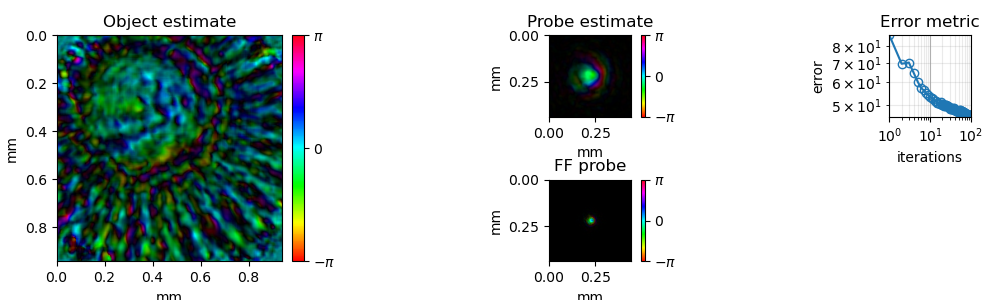

mPIE:   0%|                                                                                    | 0/100 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 250.01it/s]


mPIE:   1%|▊                                                                           | 1/100 [00:00<00:57,  1.71it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 516.63it/s]


mPIE:   2%|█▌                                                                          | 2/100 [00:01<00:47,  2.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 589.98it/s]


mPIE:   3%|██▎                                                                         | 3/100 [00:01<00:40,  2.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 574.41it/s]


mPIE:   4%|███                                                                         | 4/100 [00:01<00:37,  2.57it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 594.98it/s]


mPIE:   5%|███▊                                                                        | 5/100 [00:01<00:34,  2.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 615.19it/s]


mPIE:   6%|████▌                                                                       | 6/100 [00:02<00:32,  2.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 592.41it/s]


mPIE:   7%|█████▎                                                                      | 7/100 [00:02<00:32,  2.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 596.78it/s]


mPIE:   8%|██████                                                                      | 8/100 [00:02<00:30,  3.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 574.52it/s]


mPIE:   9%|██████▊                                                                     | 9/100 [00:03<00:29,  3.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 556.28it/s]


mPIE:  10%|███████▌                                                                   | 10/100 [00:03<00:29,  3.10it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 579.39it/s]


mPIE:  11%|████████▎                                                                  | 11/100 [00:03<00:27,  3.19it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 544.20it/s]


mPIE:  12%|█████████                                                                  | 12/100 [00:04<00:27,  3.17it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 569.31it/s]


mPIE:  13%|█████████▊                                                                 | 13/100 [00:04<00:26,  3.23it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.90it/s]


mPIE:  14%|██████████▌                                                                | 14/100 [00:04<00:26,  3.20it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 537.25it/s]


mPIE:  15%|███████████▎                                                               | 15/100 [00:05<00:27,  3.11it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 568.63it/s]


mPIE:  16%|████████████                                                               | 16/100 [00:05<00:26,  3.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 612.80it/s]


mPIE:  17%|████████████▊                                                              | 17/100 [00:05<00:26,  3.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 578.16it/s]


mPIE:  18%|█████████████▌                                                             | 18/100 [00:06<00:25,  3.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 514.73it/s]


mPIE:  19%|██████████████▎                                                            | 19/100 [00:06<00:26,  3.11it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 490.06it/s]


mPIE:  20%|███████████████                                                            | 20/100 [00:06<00:26,  3.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 479.55it/s]


mPIE:  21%|███████████████▊                                                           | 21/100 [00:07<00:26,  2.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 497.38it/s]


mPIE:  22%|████████████████▌                                                          | 22/100 [00:07<00:26,  2.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.72it/s]


mPIE:  23%|█████████████████▎                                                         | 23/100 [00:07<00:26,  2.91it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 496.76it/s]


mPIE:  24%|██████████████████                                                         | 24/100 [00:08<00:26,  2.91it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.68it/s]


mPIE:  25%|██████████████████▊                                                        | 25/100 [00:08<00:25,  2.91it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 516.33it/s]


mPIE:  26%|███████████████████▌                                                       | 26/100 [00:08<00:25,  2.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 443.38it/s]


mPIE:  27%|████████████████████▎                                                      | 27/100 [00:09<00:25,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 524.08it/s]


mPIE:  28%|█████████████████████                                                      | 28/100 [00:09<00:24,  2.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 439.80it/s]


mPIE:  29%|█████████████████████▊                                                     | 29/100 [00:09<00:24,  2.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 446.81it/s]


mPIE:  30%|██████████████████████▌                                                    | 30/100 [00:10<00:24,  2.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 442.45it/s]


mPIE:  31%|███████████████████████▎                                                   | 31/100 [00:10<00:24,  2.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 471.87it/s]


mPIE:  32%|████████████████████████                                                   | 32/100 [00:10<00:23,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 494.20it/s]


mPIE:  33%|████████████████████████▊                                                  | 33/100 [00:11<00:23,  2.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 457.52it/s]


mPIE:  34%|█████████████████████████▌                                                 | 34/100 [00:11<00:23,  2.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 515.38it/s]


mPIE:  35%|██████████████████████████▎                                                | 35/100 [00:11<00:22,  2.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 501.12it/s]


mPIE:  36%|███████████████████████████                                                | 36/100 [00:12<00:21,  2.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 463.21it/s]


mPIE:  37%|███████████████████████████▊                                               | 37/100 [00:12<00:21,  2.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.07it/s]


mPIE:  38%|████████████████████████████▌                                              | 38/100 [00:13<00:21,  2.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 485.36it/s]


mPIE:  39%|█████████████████████████████▎                                             | 39/100 [00:13<00:20,  2.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 476.22it/s]


mPIE:  40%|██████████████████████████████                                             | 40/100 [00:13<00:20,  2.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 476.21it/s]


mPIE:  41%|██████████████████████████████▋                                            | 41/100 [00:14<00:20,  2.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 497.01it/s]


mPIE:  42%|███████████████████████████████▌                                           | 42/100 [00:14<00:19,  2.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 471.55it/s]


mPIE:  43%|████████████████████████████████▎                                          | 43/100 [00:14<00:19,  2.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.46it/s]


mPIE:  44%|█████████████████████████████████                                          | 44/100 [00:15<00:19,  2.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.85it/s]


mPIE:  45%|█████████████████████████████████▊                                         | 45/100 [00:15<00:19,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 480.67it/s]


mPIE:  46%|██████████████████████████████████▌                                        | 46/100 [00:15<00:18,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 492.15it/s]


mPIE:  47%|███████████████████████████████████▎                                       | 47/100 [00:16<00:18,  2.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 493.92it/s]


mPIE:  48%|████████████████████████████████████                                       | 48/100 [00:16<00:17,  2.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 458.51it/s]


mPIE:  49%|████████████████████████████████████▊                                      | 49/100 [00:16<00:17,  2.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.86it/s]


mPIE:  50%|█████████████████████████████████████▌                                     | 50/100 [00:17<00:17,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 446.88it/s]


mPIE:  51%|██████████████████████████████████████▎                                    | 51/100 [00:17<00:17,  2.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 496.80it/s]


mPIE:  52%|███████████████████████████████████████                                    | 52/100 [00:17<00:16,  2.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 426.37it/s]


mPIE:  53%|███████████████████████████████████████▊                                   | 53/100 [00:18<00:16,  2.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 500.65it/s]


mPIE:  54%|████████████████████████████████████████▌                                  | 54/100 [00:18<00:16,  2.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 476.83it/s]


mPIE:  55%|█████████████████████████████████████████▎                                 | 55/100 [00:18<00:15,  2.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 419.26it/s]


mPIE:  56%|██████████████████████████████████████████                                 | 56/100 [00:19<00:15,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.97it/s]


mPIE:  57%|██████████████████████████████████████████▋                                | 57/100 [00:19<00:15,  2.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 452.52it/s]


mPIE:  58%|███████████████████████████████████████████▌                               | 58/100 [00:20<00:15,  2.78it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 429.83it/s]


mPIE:  59%|████████████████████████████████████████████▎                              | 59/100 [00:20<00:15,  2.72it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 463.66it/s]


mPIE:  60%|█████████████████████████████████████████████                              | 60/100 [00:20<00:14,  2.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.67it/s]


mPIE:  61%|█████████████████████████████████████████████▊                             | 61/100 [00:21<00:13,  2.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 480.41it/s]


mPIE:  62%|██████████████████████████████████████████████▌                            | 62/100 [00:21<00:13,  2.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.54it/s]


mPIE:  63%|███████████████████████████████████████████████▎                           | 63/100 [00:21<00:12,  2.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 431.67it/s]


mPIE:  64%|████████████████████████████████████████████████                           | 64/100 [00:22<00:12,  2.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 440.60it/s]


mPIE:  65%|████████████████████████████████████████████████▊                          | 65/100 [00:22<00:12,  2.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 537.70it/s]


mPIE:  66%|█████████████████████████████████████████████████▌                         | 66/100 [00:22<00:11,  2.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 539.10it/s]


mPIE:  67%|██████████████████████████████████████████████████▎                        | 67/100 [00:23<00:11,  2.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  68%|███████████████████████████████████████████████████                        | 68/100 [00:23<00:10,  3.03it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  69%|███████████████████████████████████████████████████▋                       | 69/100 [00:23<00:10,  3.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  70%|████████████████████████████████████████████████████▌                      | 70/100 [00:24<00:09,  3.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.38it/s]


mPIE:  71%|█████████████████████████████████████████████████████▎                     | 71/100 [00:24<00:09,  3.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 526.40it/s]


mPIE:  72%|██████████████████████████████████████████████████████                     | 72/100 [00:24<00:09,  3.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 492.43it/s]


mPIE:  73%|██████████████████████████████████████████████████████▊                    | 73/100 [00:25<00:08,  3.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 492.43it/s]


mPIE:  74%|███████████████████████████████████████████████████████▌                   | 74/100 [00:25<00:08,  3.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.47it/s]


mPIE:  75%|████████████████████████████████████████████████████████▎                  | 75/100 [00:25<00:08,  3.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.66it/s]


mPIE:  76%|█████████████████████████████████████████████████████████                  | 76/100 [00:26<00:07,  3.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.38it/s]


mPIE:  77%|█████████████████████████████████████████████████████████▊                 | 77/100 [00:26<00:07,  2.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 492.42it/s]


mPIE:  78%|██████████████████████████████████████████████████████████▌                | 78/100 [00:26<00:07,  3.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.99it/s]


mPIE:  79%|███████████████████████████████████████████████████████████▎               | 79/100 [00:27<00:06,  3.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  80%|████████████████████████████████████████████████████████████               | 80/100 [00:27<00:06,  3.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  81%|████████████████████████████████████████████████████████████▊              | 81/100 [00:27<00:06,  3.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 510.81it/s]


mPIE:  82%|█████████████████████████████████████████████████████████████▍             | 82/100 [00:28<00:05,  3.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  83%|██████████████████████████████████████████████████████████████▎            | 83/100 [00:28<00:05,  3.11it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  84%|███████████████████████████████████████████████████████████████            | 84/100 [00:28<00:05,  3.09it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 499.62it/s]


mPIE:  85%|███████████████████████████████████████████████████████████████▊           | 85/100 [00:29<00:04,  3.09it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  86%|████████████████████████████████████████████████████████████████▌          | 86/100 [00:29<00:04,  3.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE:  87%|█████████████████████████████████████████████████████████████████▎         | 87/100 [00:29<00:04,  3.11it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 492.36it/s]


mPIE:  88%|██████████████████████████████████████████████████████████████████         | 88/100 [00:30<00:04,  2.99it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 398.92it/s]


mPIE:  89%|██████████████████████████████████████████████████████████████████▊        | 89/100 [00:30<00:03,  2.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 443.66it/s]


mPIE:  90%|███████████████████████████████████████████████████████████████████▌       | 90/100 [00:30<00:03,  2.80it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 405.94it/s]


mPIE:  91%|████████████████████████████████████████████████████████████████████▎      | 91/100 [00:31<00:03,  2.71it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.96it/s]


mPIE:  92%|█████████████████████████████████████████████████████████████████████      | 92/100 [00:31<00:03,  2.66it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 480.25it/s]


mPIE:  93%|█████████████████████████████████████████████████████████████████████▊     | 93/100 [00:31<00:02,  2.73it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.25it/s]


mPIE:  94%|██████████████████████████████████████████████████████████████████████▌    | 94/100 [00:32<00:02,  2.78it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.72it/s]


mPIE:  95%|███████████████████████████████████████████████████████████████████████▎   | 95/100 [00:32<00:01,  2.78it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 587.25it/s]


mPIE:  96%|████████████████████████████████████████████████████████████████████████   | 96/100 [00:32<00:01,  2.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 518.34it/s]


mPIE:  97%|████████████████████████████████████████████████████████████████████████▊  | 97/100 [00:33<00:01,  2.96it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 508.88it/s]


mPIE:  98%|█████████████████████████████████████████████████████████████████████████▌ | 98/100 [00:33<00:00,  3.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.54it/s]


mPIE:  99%|██████████████████████████████████████████████████████████████████████████▎| 99/100 [00:33<00:00,  3.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.46it/s]


mPIE: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.92it/s]


In [23]:
## switch engine if you need
# switch to mPIE
mPIE = PtyLab.Engines.mPIE(reconstruction, exampleData, params,monitor)
mPIE.numIterations = 100
mPIE.betaProbe = 0.25
mPIE.betaObject = 0.25
mPIE.reconstruct()

In [16]:
## now save the data
reconstruction.saveResults('reconstruction.hdf5')

The reconstruction results (all) have been saved
